# PDC project - Channel Model

In [1]:
import numpy as np
import bitarray
import matplotlib.pyplot as plt

## Serialization

In [2]:
def string_to_bits(s):
    ba = bitarray.bitarray()
    ba.frombytes(data.encode('utf-8'))
    nparray = np.array(list(ba))
    return np.where(nparray == 0, -1, nparray)

In [3]:
def bits_to_string(bs):
    return bitarray.bitarray(list(np.where(bs == -1, 0, bs))).tobytes().decode('utf-8')

## Convolutional Encoding

### Convolutional Encoder

In [4]:
def convolutional_encoder(bs):
    bs = np.append([1, 1], bs)
    codewords = []
    
    for i in range(2, len(bs)):
        codewords.append(bs[i]*bs[i-2])
        codewords.append(bs[i]*bs[i-1]*bs[i-2])
        
    return np.array(codewords)

In [5]:
def encoder(bs, repeat):
    if repeat % 3 != 0:
        raise Exception('repeat arg. has to be a multiple of 3.')
    codewords = convolutional_encoder(bs)
    return np.repeat(codewords, repeat)

### Erasure Detection

In [6]:
def detect_erasure(dec_ys):
    bins = np.sum(np.abs(dec_ys), axis=1)
    mods = []
    for i in range(3):
        mods.append(np.sum(bins[i::3]))
    return np.argmin(mods)

In [7]:
def remove_erasures(ys, repeat):
    dec_ys = [ys[i::repeat] for i in range(repeat)]
    mod = detect_erasure(dec_ys)
    return [dec_ys[i] for i in range(repeat) if i % 3 != mod]

### Convolutional Decoder

In [8]:
def to_dec(alpha):
    return int(str(alpha[0])+str(alpha[1]), 2)

In [9]:
def convolutional_decoder(ys, maxj):
    B_matrix = [[list() for _ in range(4)] for _ in range(maxj)]
    mu_matrix = np.ones((maxj, 2, 2)) * -np.inf
    mu_matrix[0, 1, 1] = 0
    
    for j in range(1, maxj):
        max_cost = -np.inf
        max_beta = None
        for alpha in [(0,0), (0,1), (1,0), (1,1)]:
            for beta in [(0,0), (0,1), (1,0), (1,1)]:
                edge_cost = 0 ## TODO ##
                subpath_cost = mu_matrix[j-1][beta]
                cost = edge_cost + subpath_cost
                if (cost > max_cost):
                    max_cost = cost
                    max_beta = beta
            mu_matrix[j][alpha] = max_cost
            B_matrix[j][to_dec(alpha)] = B_matrix[j-1][to_dec(max_beta)] + None # ## TODO ##
    
    return B_matrix[maxj][to_dec((1,1))][:k]

In [10]:
def decoder(ys, repeat): ## TODO ##
    if repeat % 3 != 0:
        raise Exception('repeat arg. has to be a multiple of 3.')
    yss = remove_erasures(ys, repeat)
    return yss
    #dec = []
    #for ys in yss:
        #dec.append(convolutional_decoder(ys, len(ys/2) + 2))
    # fais un systeme de vote ?
    #return dec[0]

## Server Pipeline

In [11]:
def encode(filename, repeat = 3):
    file = open(filename, 'r')
    data = file.read()
    file.close()
    
    bits = string_to_bits(data)
    xs = encoder(bits, 3)
    np.savetxt(filename[:-4] + '-encoded.txt', xs)

In [12]:
def decode(filename, repeat = 3):
    ys = np.loadtxt(filename)
    bits = decoder(ys, repeat)
    data = bits_to_string(bits)
    
    file = open(filename[:-4] + '-decoded.txt', 'w')
    file.write(data)
    file.close()

## Channel Models

In [13]:
def silent_channel(chanInput):
    chanInput = np.clip(chanInput,-1,1)
    erasedIndex = np.random.randint(3)
    chanInput[erasedIndex:len(chanInput):3] = 0
    return chanInput, erasedIndex

In [14]:
def noisy_channel(chanInput, var = 10):
    chanInput = np.clip(chanInput,-1,1)
    erasedIndex = np.random.randint(3)
    chanInput[erasedIndex:len(chanInput):3] = 0
    return chanInput + np.sqrt(var)*np.random.randn(len(chanInput)), erasedIndex

---
# Test section

## Serialization

In [15]:
data = open('files/input.txt', 'r').read()

In [16]:
bits_to_string(string_to_bits(data))

"Ceci est un test. Je m'appelle Antoine et j'écris des accents pour faire des tests.\n😀\n"

## Erasure detection

In [17]:
data = open('files/input.txt', 'r').read()
bits = string_to_bits(data)

In [18]:
def detect_erasure_test(channel, repeats = 30, iters = 100):
    errors = {}
    logs = {}
    
    for rep in range(3, repeats, 3):
        xs = np.repeat(bits, rep)

        loc_err = 0
        loc_logs = {}

        for i in range(iters):
            xsi, ei = channel(xs)
            dec_xsi = [xsi[i::rep] for i in range(rep)]
            mod = detect_erasure(dec_xsi)
            if ei != mod:
                loc_err += 1
                loc_logs[i] = {
                    'xs': xsi,
                    'dec_xs': dec_xsi,
                    'ei': ei,
                    'mod': mod
                }

        errors[rep] = loc_err
        logs[rep] = loc_logs
    
    return errors, logs

### Over silent channel

In [19]:
errors, _ = detect_erasure_test(silent_channel, 15, 100)

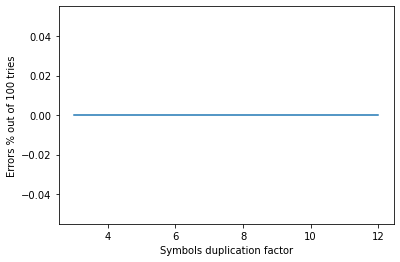

In [20]:
plt.plot(list(errors.keys()), list(errors.values()))
plt.xlabel('Symbols duplication factor')
plt.ylabel(f'Errors % out of {100} tries')
plt.show()

### Over noisy channel

In [21]:
repeats, iters = 60, 300
errors, logs = detect_erasure_test(noisy_channel, repeats, iters)

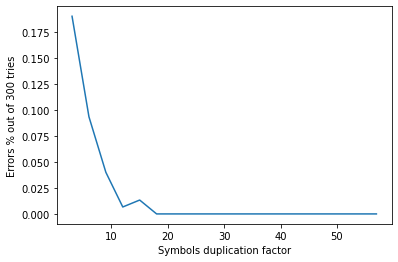

In [22]:
plt.plot(list(errors.keys()), np.array(list(errors.values()))/iters)
plt.xlabel('Symbols duplication factor')
plt.ylabel(f'Errors % out of {iters} tries')
plt.show()

## Encoder

## Decoder

## Server Pipeline

In [23]:
encode('files/input.txt')

---
# *TODO*

- Finir conv. decoder
- Se poser sur le système de votes
- Find optimal *repeat* parameter ***DONE***


- Pipeline server (easy) ***DONE***
- Tester pipeline server ***DONE***


- Faire des vrais tests avec zero noise ***DONE***
- Faire des vrais tests avec peu noise local
- Faire des vrais tests avec real noise local